<a href="https://colab.research.google.com/github/yeonmi02/mlproject/blob/main/data_%EC%A0%84%EC%B2%98%EB%A6%AC_prophet_%EC%8B%A4%ED%96%89%EA%B2%B0%EA%B3%BC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from prophet import Prophet
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

traffic_2 = pd.read_csv('/content/drive/MyDrive/TrafficTwoMonth.csv')
traffic_2.head(10)

,Time,Date,Day of the week,CarCount,BikeCount,BusCount,TruckCount,Total,Traffic Situation
0,12:00:00 AM,10,Tuesday,13,2,2,24,41,normal
1,12:15:00 AM,10,Tuesday,14,1,1,36,52,normal
2,12:30:00 AM,10,Tuesday,10,2,2,32,46,normal
3,12:45:00 AM,10,Tuesday,10,2,2,36,50,normal
4,1:00:00 AM,10,Tuesday,11,2,1,34,48,normal
5,1:15:00 AM,10,Tuesday,15,1,1,39,56,normal
6,1:30:00 AM,10,Tuesday,14,2,2,27,45,normal
7,1:45:00 AM,10,Tuesday,13,2,1,20,36,normal
8,2:00:00 AM,10,Tuesday,7,0,0,26,33,normal
9,2:15:00 AM,10,Tuesday,13,0,0,34,47,normal


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#데이터 전처리

In [ ]:
import numpy as np

# 시간 데이터를 데이트타임으로 변환
traffic_2['Datetime'] = pd.to_datetime(traffic_2['Date'].astype(str) + ' ' + traffic_2['Time'], format='%d %I:%M:%S %p', errors='coerce')

In [ ]:
# 필요하지 않은 특성 제거
traffic_2.drop(columns=['Time', 'Date'], inplace=True)

In [ ]:
# 범주형 변수를 인코딩
traffic_2['Day of the week'] = traffic_2['Day of the week'].astype('category')
traffic_2['Traffic Situation'] = traffic_2['Traffic Situation'].astype('category')

In [ ]:
# 원-핫 인코딩
traffic_2 = pd.get_dummies(traffic_2, columns=['Day of the week', 'Traffic Situation'])

In [ ]:
# 결측치 처리
traffic_2 = traffic_2.dropna(subset=['Datetime'])

In [ ]:
# 특성 정리
cols = ['Datetime'] + [col for col in traffic_2.columns if col != 'Datetime']
traffic_2 = traffic_2[cols]

In [ ]:
# 저장하고 확인
traffic_2.to_csv('/content/ProcessedTraffic.csv', index=False)
traffic_2.head()

,Datetime,CarCount,BikeCount,BusCount,TruckCount,Total,Day of the week_Friday,Day of the week_Monday,Day of the week_Saturday,Day of the week_Sunday,Day of the week_Thursday,Day of the week_Tuesday,Day of the week_Wednesday,Traffic Situation_heavy,Traffic Situation_high,Traffic Situation_low,Traffic Situation_normal
0,1900-01-10 00:00:00,13,2,2,24,41,False,False,False,False,False,True,False,False,False,False,True
1,1900-01-10 00:15:00,14,1,1,36,52,False,False,False,False,False,True,False,False,False,False,True
2,1900-01-10 00:30:00,10,2,2,32,46,False,False,False,False,False,True,False,False,False,False,True
3,1900-01-10 00:45:00,10,2,2,36,50,False,False,False,False,False,True,False,False,False,False,True
4,1900-01-10 01:00:00,11,2,1,34,48,False,False,False,False,False,True,False,False,False,False,True


In [ ]:
# 수치형 특성 확인하기
numeric_cols = ['CarCount', 'BikeCount', 'BusCount', 'TruckCount', 'Total']

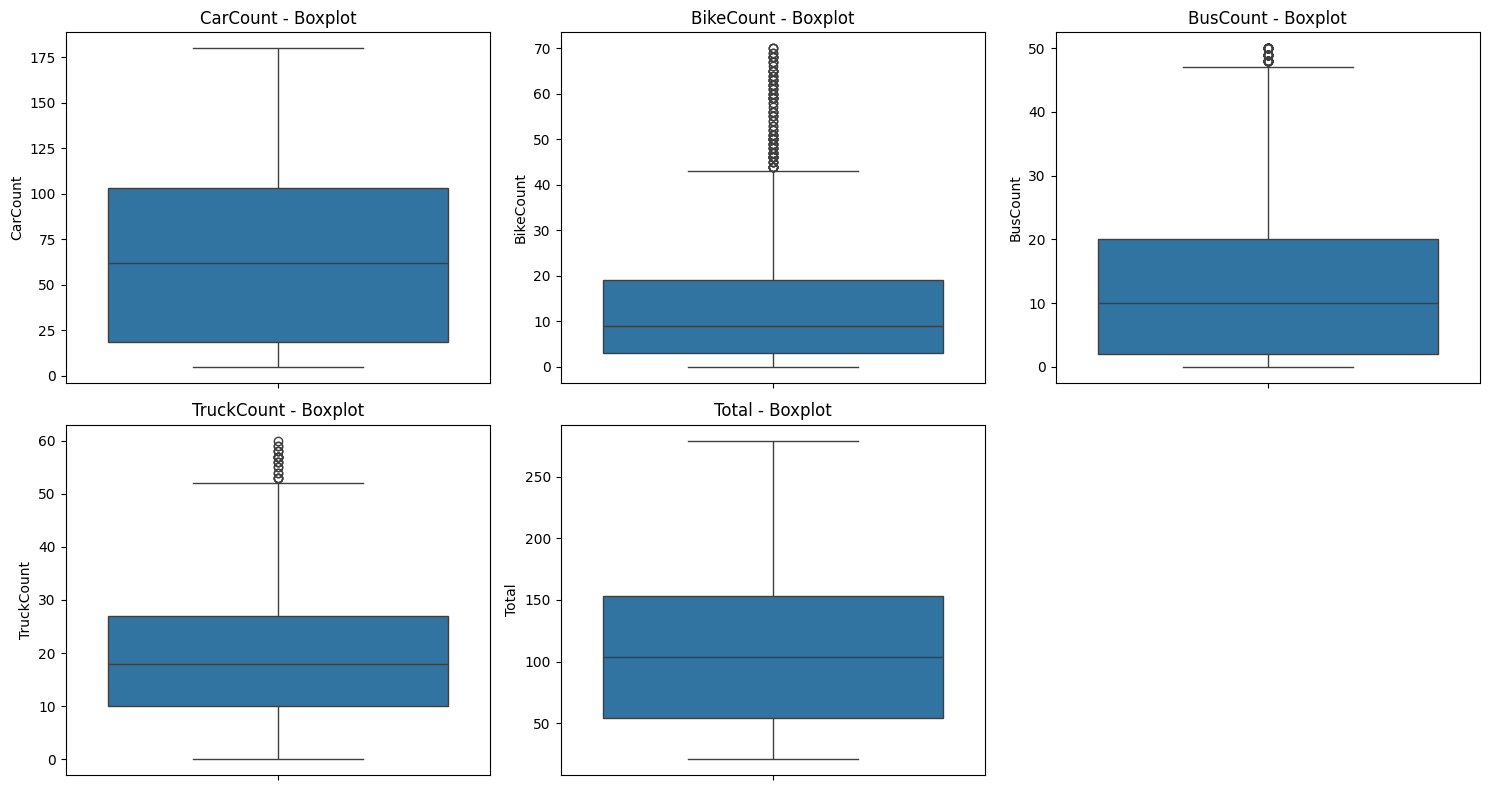

In [ ]:
# 이상치 탐지
plt.figure(figsize=(15, 8))
for i, col in enumerate(numeric_cols, 1):
    plt.subplot(2, 3, i)
    sns.boxplot(y=traffic_2[col])
    plt.title(f'{col} - Boxplot')
plt.tight_layout()
plt.show()

In [ ]:
traffic_2['Datetime'] = pd.to_datetime(traffic_2['Datetime'])
traffic_2.set_index('Datetime', inplace=True)

In [ ]:
numeric_cols = ['CarCount', 'BikeCount', 'BusCount', 'TruckCount', 'Total']
traffic_2_num = traffic_2[numeric_cols].resample('30T').mean()

<ipython-input-13-2b676e985bee>:2: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  traffic_2_num = traffic_2[numeric_cols].resample('30T').mean()


In [ ]:
print(traffic_2.columns.tolist())

['CarCount', 'BikeCount', 'BusCount', 'TruckCount', 'Total', 'Day of the week_Friday', 'Day of the week_Monday', 'Day of the week_Saturday', 'Day of the week_Sunday', 'Day of the week_Thursday', 'Day of the week_Tuesday', 'Day of the week_Wednesday', 'Traffic Situation_heavy', 'Traffic Situation_high', 'Traffic Situation_low', 'Traffic Situation_normal']


In [ ]:
categorical_cols = [ 'Day of the week_Friday', 'Day of the week_Monday', 'Day of the week_Saturday', 'Day of the week_Sunday', 'Day of the week_Thursday', 'Day of the week_Tuesday', 'Day of the week_Wednesday', 'Traffic Situation_heavy', 'Traffic Situation_high', 'Traffic Situation_low', 'Traffic Situation_normal']
def mode_agg(x):
    return x.mode()[0] if not x.mode().empty else np.nan
traffic_2_cat = traffic_2[categorical_cols].resample('30T').agg(mode_agg)

<ipython-input-15-139bc3a2e256>:4: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  traffic_2_cat = traffic_2[categorical_cols].resample('30T').agg(mode_agg)


In [ ]:
traffic_2_30min = pd.concat([traffic_2_num, traffic_2_cat], axis=1).reset_index()

In [ ]:
print(traffic_2_30min.head(10))

             Datetime  CarCount  BikeCount  BusCount  TruckCount   Total  \
0 1900-01-01 00:00:00     13.75       2.00      0.25       31.50   47.50   
1 1900-01-01 00:30:00     15.50       1.75      0.75       25.25   43.25   
2 1900-01-01 01:00:00     11.50       1.50      0.50       29.25   42.75   
3 1900-01-01 01:30:00     15.25       1.75      1.00       19.75   37.75   
4 1900-01-01 02:00:00     13.00       2.00      0.50       27.25   42.75   
5 1900-01-01 02:30:00      9.50       0.50      0.50       29.50   40.00   
6 1900-01-01 03:00:00     13.75       2.75      1.00       31.25   48.75   
7 1900-01-01 03:30:00     13.00       2.00      0.50       25.00   40.50   
8 1900-01-01 04:00:00     57.50       8.50      3.00       12.00   81.00   
9 1900-01-01 04:30:00     75.75      13.25      4.00       21.75  114.75   

   Day of the week_Friday  Day of the week_Monday  Day of the week_Saturday  \
0                   False                   False                     False   
1    

In [ ]:
print(traffic_2_30min['Datetime'].diff().value_counts())

Datetime
0 days 00:30:00    1487
Name: count, dtype: int64


In [ ]:
print(f"원본 데이터 개수: {len(traffic_2)}")
print(f"30분 단위 데이터 개수: {len(traffic_2_30min)}")

원본 데이터 개수: 5952
30분 단위 데이터 개수: 1488


In [ ]:
plt.figure(figsize=(14, 6))
vehicle_cols = ['CarCount', 'BikeCount', 'BusCount', 'TruckCount']

<Figure size 1400x600 with 0 Axes>

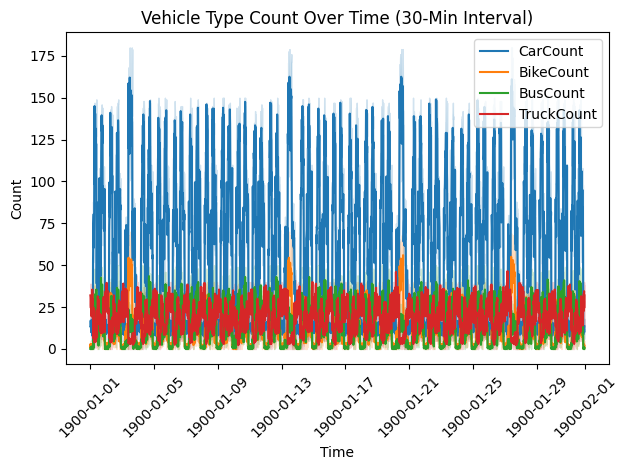

In [ ]:
for col in vehicle_cols:
    sns.lineplot(data=traffic_2, x='Datetime', y=col, label=col)

plt.title('Vehicle Type Count Over Time (30-Min Interval)')
plt.xlabel('Time')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

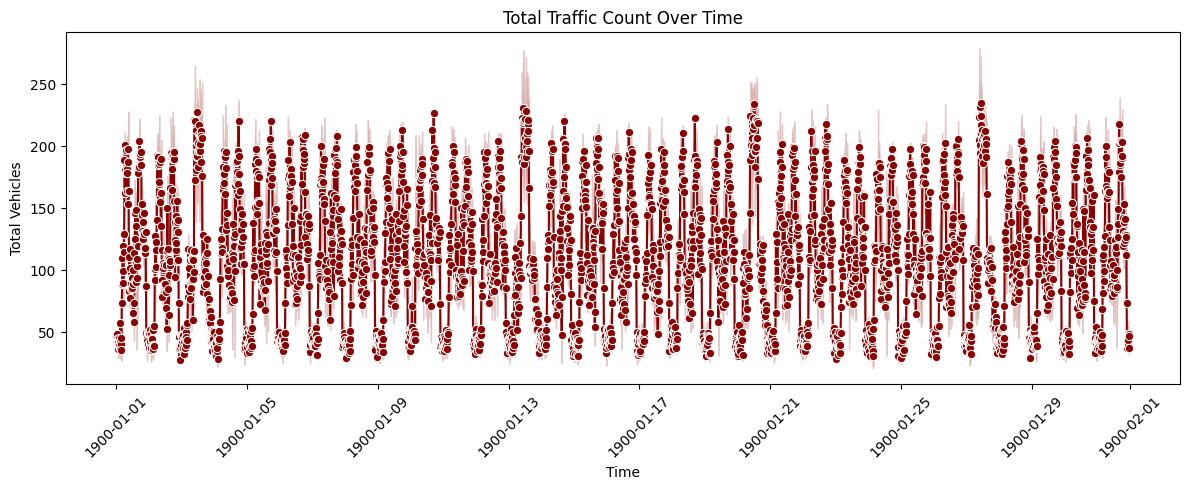

In [ ]:
plt.figure(figsize=(12, 5))
sns.lineplot(data=traffic_2, x='Datetime', y='Total', color='darkred', marker='o')
plt.title('Total Traffic Count Over Time')
plt.xlabel('Time')
plt.ylabel('Total Vehicles')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

<ipython-input-23-3eee7d3076a0>:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=traffic_2, x='weekday', y='Total', estimator='mean', order=[


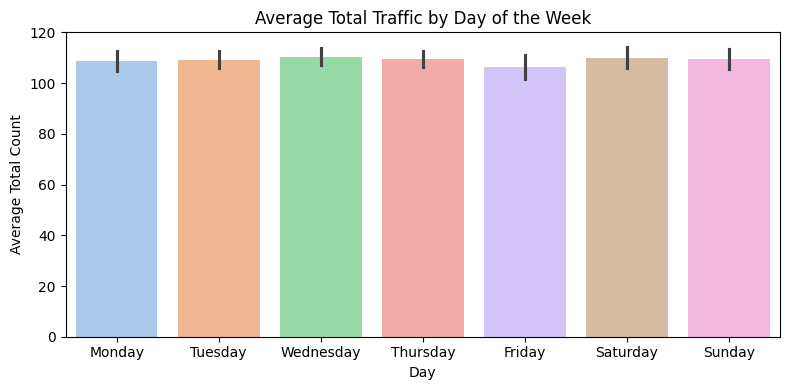

In [ ]:
weekday_cols = [
    'Day of the week_Monday', 'Day of the week_Tuesday', 'Day of the week_Wednesday',
    'Day of the week_Thursday', 'Day of the week_Friday',
    'Day of the week_Saturday', 'Day of the week_Sunday'
]

traffic_2['weekday'] = traffic_2[weekday_cols].idxmax(axis=1).str.replace('Day of the week_', '')

plt.figure(figsize=(8, 4))
sns.barplot(data=traffic_2, x='weekday', y='Total', estimator='mean', order=[
    'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'
], palette='pastel')
plt.title('Average Total Traffic by Day of the Week')
plt.xlabel('Day')
plt.ylabel('Average Total Count')
plt.tight_layout()
plt.show()

<ipython-input-24-332f1d1357b4>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=traffic_2, x='traffic_level', y='Total', palette='Set2',


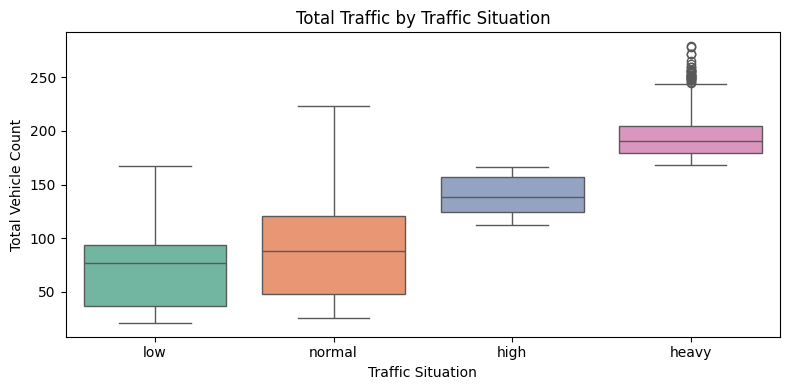

In [ ]:
traffic_cols = [
    'Traffic Situation_low', 'Traffic Situation_normal',
    'Traffic Situation_high', 'Traffic Situation_heavy'
]

traffic_2['traffic_level'] = traffic_2[traffic_cols].idxmax(axis=1).str.replace('Traffic Situation_', '')

plt.figure(figsize=(8, 4))
sns.boxplot(data=traffic_2, x='traffic_level', y='Total', palette='Set2',
            order=['low', 'normal', 'high', 'heavy'])
plt.title('Total Traffic by Traffic Situation')
plt.xlabel('Traffic Situation')
plt.ylabel('Total Vehicle Count')
plt.tight_layout()
plt.show()

# Prophet 모델 구현하기

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpfy2k86d2/ah2mglk5.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpfy2k86d2/ao_4c6zw.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=3788', 'data', 'file=/tmp/tmpfy2k86d2/ah2mglk5.json', 'init=/tmp/tmpfy2k86d2/ao_4c6zw.json', 'output', 'file=/tmp/tmpfy2k86d2/prophet_modelm1wdd55e/prophet_model-20250601134410.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:44:10 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:44:10 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 44368 (\N{HANGUL SYLLABLE GYO}) missing from font(

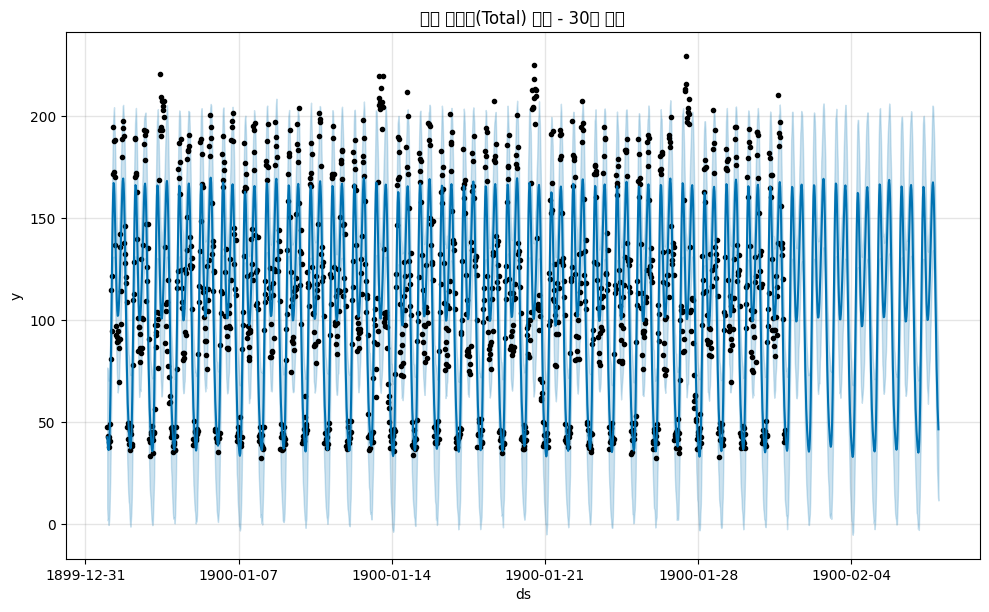

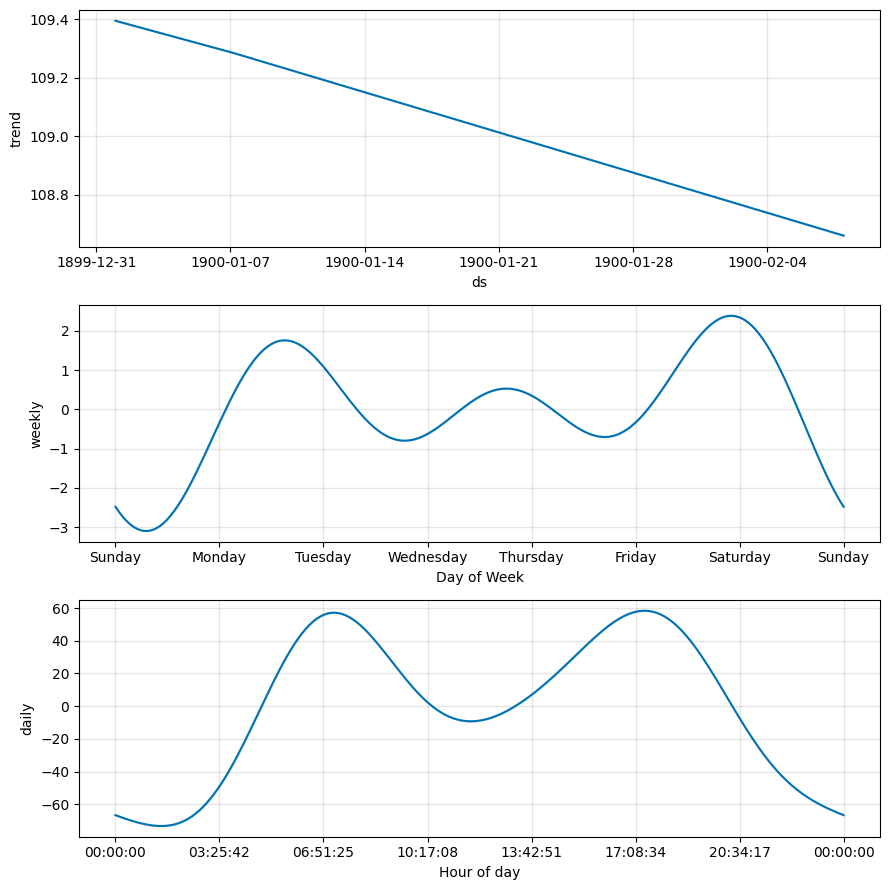

In [ ]:
from prophet import Prophet
import matplotlib.pyplot as plt

df_prophet = traffic_2_30min[['Datetime', 'Total']].rename(columns={
    'Datetime': 'ds',
    'Total': 'y'
})

# 결측치 제거 (예측 실패 방지)
df_prophet.dropna(subset=['ds', 'y'], inplace=True)

# Prophet 모델 초기화 (일일 seasonality은 시간대별 패턴용, 주간도 포함)
model = Prophet(daily_seasonality=True, weekly_seasonality=True)

# 모델 학습
model.fit(df_prophet)

# 예측할 기간 생성 (예: 7일 = 30분 단위로 48*7 = 336 스텝)
future = model.make_future_dataframe(periods=336, freq='30min')

# 예측 수행
forecast = model.predict(future)

# 예측 결과 시각화
model.plot(forecast)
plt.title('교통 혼잡도(Total) 예측 - 30분 단위')
plt.show()

# 구성 요소별 시각화 (추세, 일간/주간 패턴 등)
model.plot_components(forecast)
plt.show()

# 랜덤프로스트 모델 구현하기

Mean Squared Error: 9.44
R2 Score: 0.9965


<ipython-input-26-133cda3f0a57>:36: UserWarning: Glyph 50696 (\N{HANGUL SYLLABLE YE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-26-133cda3f0a57>:36: UserWarning: Glyph 52769 (\N{HANGUL SYLLABLE CEUG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-26-133cda3f0a57>:36: UserWarning: Glyph 49892 (\N{HANGUL SYLLABLE SIL}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-26-133cda3f0a57>:36: UserWarning: Glyph 51228 (\N{HANGUL SYLLABLE JE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 50696 (\N{HANGUL SYLLABLE YE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 52769 (\N{HANGUL SYLLABLE CEUG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-pack

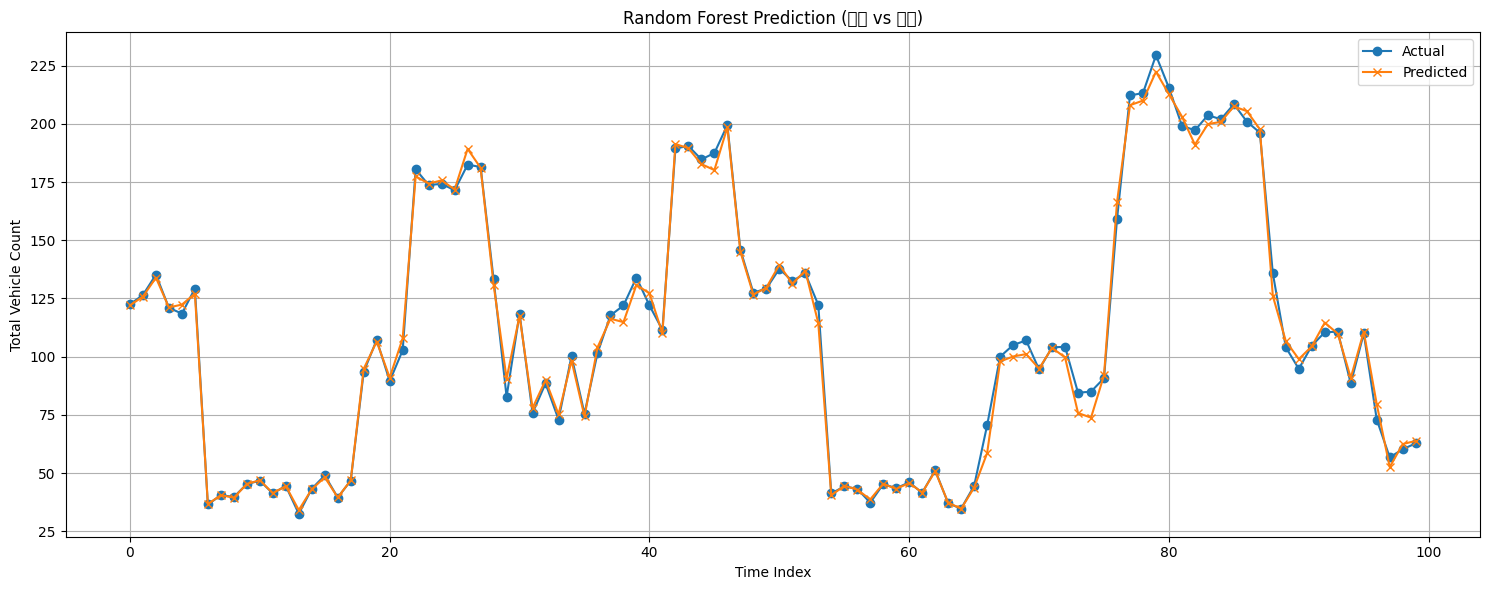

In [ ]:
# 예측 대상 변수 (y)와 특성 (X) 지정
target_col = 'Total'
feature_cols = [col for col in traffic_2_30min.columns if col not in ['Datetime', target_col]]

X = traffic_2_30min[feature_cols]
y = traffic_2_30min[target_col]

# 훈련/테스트 데이터 나누기 (8:2 비율)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# 랜덤 포레스트 회귀 모델 생성 및 학습
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# 예측
y_pred = model.predict(X_test)

# 성능 평가
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Mean Squared Error: {mse:.2f}')
print(f'R2 Score: {r2:.4f}')

# 실제 vs 예측 시각화
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 6))
plt.plot(y_test.values[:100], label='Actual', marker='o')
plt.plot(y_pred[:100], label='Predicted', marker='x')
plt.title('Random Forest Prediction (예측 vs 실제)')
plt.xlabel('Time Index')
plt.ylabel('Total Vehicle Count')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()